In [35]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier,LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.decomposition import PCA
from scipy.special import expit
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
df = pd.read_csv('DataFiles/combined1.csv')
# read in the combined1.csv file made in the preprocessing stage

# df = pd.read_csv('combined1.csv') #uncomment this to run this in your computer

In [3]:
df.columns

Index(['game_id', 'posteam', 'defteam', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'qtr', 'down', 'ydstogo', 'play_type',
       'yards_gained', 'shotgun', 'no_huddle', 'score_differential',
       'rush_attempt', 'pass_attempt', 'Field_Goal_Range', 'first_down_dis',
       'encoded_plays', 'encoded_off_teams', 'encoded_def_teams'],
      dtype='object')

## BASELINE MODEL PREDICTS PASS EVERYTIME

In [4]:
df['play_type'].value_counts(normalize=True)*100

pass    59.141491
run     40.858509
Name: play_type, dtype: float64

Has 59% accuracy at the time


In [5]:
y_pred_baseline = []
for i in range(df.shape[0]):
    y_pred_baseline.append(1)
# predict a pass play every time

In [7]:
X =  df.drop(['play_type','yards_gained','encoded_plays','game_id','posteam','defteam','game_date','rush_attempt','pass_attempt','ydstogo'],1)
Y = df['encoded_plays']
y_actual = list(Y)
X

,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,qtr,down,shotgun,no_huddle,score_differential,Field_Goal_Range,first_down_dis,encoded_off_teams,encoded_def_teams
0,87.0,896.0,1796.0,3596.0,1,1.0,0,0,0.0,4,3,11,27
1,76.0,851.0,1751.0,3551.0,1,1.0,1,0,0.0,4,3,11,27
2,61.0,812.0,1712.0,3512.0,1,1.0,0,1,0.0,4,3,11,27
3,59.0,786.0,1686.0,3486.0,1,2.0,1,0,0.0,4,2,11,27
4,61.0,750.0,1650.0,3450.0,1,3.0,1,0,0.0,4,3,11,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158153,71.0,82.0,82.0,82.0,4,2.0,1,1,-5.0,4,1,4,21
158154,71.0,77.0,77.0,77.0,4,3.0,1,0,-5.0,4,1,4,21
158155,66.0,63.0,63.0,63.0,4,2.0,1,0,-5.0,4,3,4,21
158156,66.0,58.0,58.0,58.0,4,3.0,1,0,-5.0,4,3,4,21


In [8]:
tn, fp, fn, tp = confusion_matrix(y_actual, y_pred_baseline).ravel()
print(tn, fp, fn, tp)

0 64621 0 93537


In [9]:
print(classification_report(y_actual,y_pred_baseline))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     64621
           1       0.59      1.00      0.74     93537

    accuracy                           0.59    158158
   macro avg       0.30      0.50      0.37    158158
weighted avg       0.35      0.59      0.44    158158



/Users/shounakrangwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2)

In [11]:
scaled = StandardScaler().fit(x_train)
x_train = scaled.transform(x_train)
x_test  =scaled.transform(x_test)

In [13]:
x_train.shape

(126526, 13)

## LOGISTIC REGRESSION

In [14]:
Log_Reg = LogisticRegression(max_iter = 10000).fit(x_train,y_train)


In [15]:
Log_Reg.classes_

array([0, 1])

In [16]:
log_reg_pred = Log_Reg.predict(x_test)

In [17]:
print(classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64     12840
           1       0.75      0.79      0.77     18792

    accuracy                           0.72     31632
   macro avg       0.71      0.70      0.71     31632
weighted avg       0.72      0.72      0.72     31632



In [18]:
print(accuracy_score(y_test,log_reg_pred))

0.720030349013657


### Finding the best parameters

In [19]:
clf_LR = LogisticRegression()
parameters = {'penalty': ['l1','l2'],
              'solver': ['newton-cg','sag','lbfgs'],
              'max_iter': [1000,5000,10000,20000]
             }
Folds = 10
kfold_10 = KFold(n_splits= Folds, shuffle = False)

clf = RandomizedSearchCV(clf_LR, 
                         param_distributions = parameters,
                         cv = kfold_10,  
                         n_iter = 1,
                         scoring = 'recall', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.6s finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=0, estimator=LogisticRegression(), n_iter=1,
                   n_jobs=-1,
                   param_distributions={'max_iter': [1000, 5000, 10000, 20000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'sag',
                                                   'lbfgs']},
                   scoring='recall', verbose=3)

In [20]:
y_pred = clf.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64     12840
           1       0.75      0.79      0.77     18792

    accuracy                           0.72     31632
   macro avg       0.71      0.70      0.71     31632
weighted avg       0.72      0.72      0.72     31632



In [21]:
clf.best_estimator_

LogisticRegression(max_iter=10000, solver='newton-cg')

## LOGISTIC REGRESSION WITH RIDGE CLASSIFIER

In [55]:
Ridge_Reg = RidgeClassifier(normalize = True,solver='lsqr').fit(x_train,y_train)

In [56]:
ridge_pred = Ridge_Reg.predict(x_test)

In [57]:
print(classification_report(y_test, ridge_pred))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61     12840
           1       0.73      0.81      0.77     18792

    accuracy                           0.71     31632
   macro avg       0.70      0.69      0.69     31632
weighted avg       0.71      0.71      0.71     31632



In [58]:
print(accuracy_score(y_test,ridge_pred))

0.7106727364693981


### Finding best paramemters

In [77]:
clf_RR = RidgeClassifier()
parameters = {'alpha': [1.0,2.5,1.5,0.1,5.0],
              'solver': ['svd','sag','sparse_cg','lsqr'],
              'max_iter': [1000,5000,10000,20000]
             }
Folds = 10
kfold_10 = KFold(n_splits= Folds, shuffle = False)

clf = RandomizedSearchCV(clf_RR, 
                         param_distributions = parameters,
                         cv = kfold_10,  
                         n_iter = 1,
                         scoring = 'recall', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.1s finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=0, estimator=RidgeClassifier(), n_iter=1,
                   n_jobs=-1,
                   param_distributions={'alpha': [1.0, 2.5, 1.5, 0.1, 5.0],
                                        'max_iter': [1000, 5000, 10000, 20000],
                                        'solver': ['svd', 'sag', 'sparse_cg',
                                                   'lsqr']},
                   scoring='recall', verbose=3)

In [78]:
y_pred = clf.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.62      0.65     12840
           1       0.75      0.79      0.77     18792

    accuracy                           0.72     31632
   macro avg       0.71      0.71      0.71     31632
weighted avg       0.72      0.72      0.72     31632



In [79]:
clf.best_estimator_

RidgeClassifier(alpha=5.0, max_iter=20000, solver='sag')

## NEURAL NETWORK (PERCEPTRON)

In [37]:
perceptron = MLPClassifier().fit(x_train,y_train)

/Users/shounakrangwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [76]:
per_pred = perceptron.predict(x_test)

In [77]:
print(classification_report(y_test, per_pred))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65     12879
           1       0.76      0.79      0.77     18753

    accuracy                           0.73     31632
   macro avg       0.72      0.71      0.71     31632
weighted avg       0.72      0.73      0.72     31632



In [78]:
print(accuracy_score(y_test,per_pred))

0.7261001517450683


In [79]:
clf_NN = MLPClassifier()
parameters = {'alpha': [0.0001,0.001,0.01,0.1],
              'solver': ['lbfgs','sgd'],
              'hidden_layer_sizes': [(20,50,30),(50,100,50),(28,50,30,14),(100,)],
              'activation':['tanh','relu'],
              'batch_size':[100,1000,10000],
              'learning_rate':['constant','adaptive']
             }
Folds = 10
kfold_10 = KFold(n_splits= Folds, shuffle = False)

clf = RandomizedSearchCV(clf_NN, 
                         param_distributions = parameters,
                         cv = kfold_10,  
                         n_iter = 1,
                         scoring = 'recall', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  8.1min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.2min finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=0, estimator=MLPClassifier(), n_iter=1,
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'batch_size': [100, 1000, 10000],
                                        'hidden_layer_sizes': [(20, 50, 30),
                                                               (50, 100, 50),
                                                               (28, 50, 30, 14),
                                                               (100,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['lbfgs', 'sgd']},
                   scoring='recall', verbose=3)

In [80]:
y_pred = clf.predict(x_test)
print(classification_report(y_test,y_pred))
clf.best_estimator_

              precision    recall  f1-score   support

           0       0.66      0.65      0.66     12879
           1       0.76      0.78      0.77     18753

    accuracy                           0.72     31632
   macro avg       0.71      0.71      0.71     31632
weighted avg       0.72      0.72      0.72     31632



MLPClassifier(batch_size=1000, hidden_layer_sizes=(50, 100, 50), solver='sgd')

## KNN CLASSIFIER

In [81]:
knn_classifier = KNeighborsClassifier().fit(x_train,y_train)

In [82]:
knn_pred = knn_classifier.predict(x_test)

In [83]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.62      0.59      0.60     12879
           1       0.73      0.76      0.74     18753

    accuracy                           0.69     31632
   macro avg       0.68      0.67      0.67     31632
weighted avg       0.68      0.69      0.69     31632



In [84]:
print(accuracy_score(y_test,knn_pred))

0.687373545776429


### Finding the best parameters

In [85]:
clf_KNN = KNeighborsClassifier()
parameters = {'n_neighbors': [5,10,15],
              'weights': ['uniform','distance'],
              'algorithm': ['ball_tree','kd_tree']
             }
Folds = 10
kfold_10 = KFold(n_splits= Folds, shuffle = False)

clf = RandomizedSearchCV(clf_KNN, 
                         param_distributions = parameters,
                         cv = kfold_10,  
                         n_iter = 1,
                         scoring = 'recall', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.1min finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=0, estimator=KNeighborsClassifier(), n_iter=1,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'n_neighbors': [5, 10, 15],
                                        'weights': ['uniform', 'distance']},
                   scoring='recall', verbose=3)

In [86]:
y_pred = clf.predict(x_test)
print(classification_report(y_test,y_pred))
clf.best_estimator_

              precision    recall  f1-score   support

           0       0.62      0.59      0.61     12879
           1       0.73      0.76      0.74     18753

    accuracy                           0.69     31632
   macro avg       0.68      0.67      0.67     31632
weighted avg       0.69      0.69      0.69     31632



KNeighborsClassifier(algorithm='ball_tree', weights='distance')

##  RANDOM FOREST CLASSIFIER

In [80]:
ran_for = RandomForestClassifier().fit(x_train,y_train)

In [81]:
ranFor_pred = ran_for.predict(x_test)

In [82]:
print(classification_report(y_test, ranFor_pred))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65     12840
           1       0.76      0.78      0.77     18792

    accuracy                           0.72     31632
   macro avg       0.71      0.71      0.71     31632
weighted avg       0.72      0.72      0.72     31632



### find the feature importances

In [83]:
ran_for.feature_importances_

array([0.11142281, 0.10996415, 0.11807768, 0.11481636, 0.0139886 ,
       0.0505227 , 0.1353212 , 0.0088208 , 0.09550567, 0.01633157,
       0.03254873, 0.09544368, 0.09723603])

<BarContainer object of 13 artists>

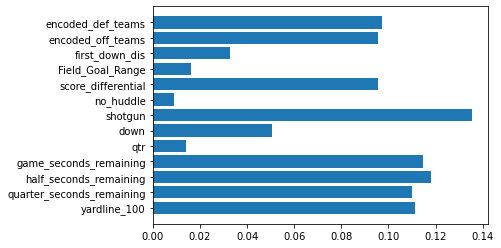

In [84]:
importantFeatures = []
theirValues =[]
for index, value in enumerate(ran_for.feature_importances_):
    importantFeatures.append(X.columns[index])
    theirValues.append(value)

plt.barh(importantFeatures,theirValues)

In [85]:
clf_RF = RandomForestClassifier()
parameters = {'n_estimators': [50,100,150],
              'criterion': ['gini','entropy'],
              'max_depth': [10,15,20]
             }
Folds = 10
kfold_10 = KFold(n_splits= Folds, shuffle = False)

clf = RandomizedSearchCV(clf_RF, 
                         param_distributions = parameters,
                         cv = kfold_10,  
                         n_iter = 1,
                         scoring = 'recall', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.0min remaining:   52.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=0, estimator=RandomForestClassifier(), n_iter=1,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 15, 20],
                                        'n_estimators': [50, 100, 150]},
                   scoring='recall', verbose=3)

In [86]:
y_pred = clf.predict(x_test)
print(classification_report(y_test,y_pred))
clf.best_estimator_

              precision    recall  f1-score   support

           0       0.68      0.65      0.66     12840
           1       0.77      0.79      0.78     18792

    accuracy                           0.73     31632
   macro avg       0.72      0.72      0.72     31632
weighted avg       0.73      0.73      0.73     31632



RandomForestClassifier(max_depth=15, n_estimators=150)

In [87]:
ran_for=clf.best_estimator_

<BarContainer object of 13 artists>

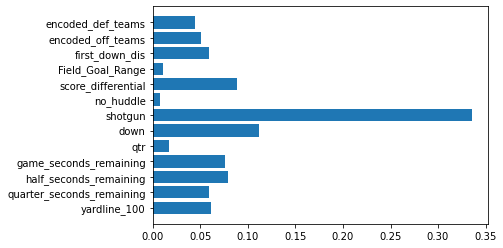

In [88]:
ran_for = ran_for.fit(x_train,y_train)
ranFor_pred = ran_for.predict(x_test)
importantFeatures = []
theirValues =[]
for index, value in enumerate(ran_for.feature_importances_):
    importantFeatures.append(X.columns[index])
    theirValues.append(value)

plt.barh(importantFeatures,theirValues)

## GRADIENT BOOSTING CLASSIFIER

In [96]:
GBC = GradientBoostingClassifier().fit(x_train,y_train)

In [97]:
gbc_pred = GBC.predict(x_test)

In [98]:
GBC.n_classes_

2

In [99]:
print(classification_report(y_test, ranFor_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65     12879
           1       0.76      0.79      0.77     18753

    accuracy                           0.73     31632
   macro avg       0.72      0.71      0.71     31632
weighted avg       0.72      0.73      0.72     31632



In [100]:
clf_gbc = GradientBoostingClassifier()
parameters = {'n_estimators': [10,50],
              'learning_rate': [0.05,0.5,1.0],
              'loss': ['deviance','exponential'],
              'max_depth': [5,6,8],
              'random_state': [1,2,5],
              'criterion': ['friedman_mse','mse']
             }
Folds = 10
kfold_5 = KFold(n_splits= Folds, shuffle = False)

clf = RandomizedSearchCV(clf_gbc, 
                         param_distributions = parameters,
                         cv = kfold_5,  
                         n_iter = 1,
                         scoring = 'recall', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.4min remaining:   35.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=0, estimator=GradientBoostingClassifier(),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse', 'mse'],
                                        'learning_rate': [0.05, 0.5, 1.0],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [5, 6, 8],
                                        'n_estimators': [10, 50],
                                        'random_state': [1, 2, 5]},
                   scoring='recall', verbose=3)

In [101]:
y_pred = clf.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65     12879
           1       0.76      0.78      0.77     18753

    accuracy                           0.72     31632
   macro avg       0.71      0.71      0.71     31632
weighted avg       0.72      0.72      0.72     31632



In [102]:
clf.best_estimator_

GradientBoostingClassifier(learning_rate=1.0, loss='exponential', max_depth=5,
                           n_estimators=50, random_state=5)